In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as dataset
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(0)

In [2]:
# Create Dataset
train_dataset = dataset.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
valid_dataset = dataset.MNIST(root='./data', download=True, transform=transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 84451125.31it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 72449577.65it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27038859.77it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5049172.75it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
trainloader = DataLoader(dataset=train_dataset, batch_size=2000, shuffle=True)
validloader = DataLoader(dataset=valid_dataset, batch_size=5000, shuffle=False)

In [4]:
# Create Module with Batch Normalization
class ANN_BN(nn.Module):
  def __init__(self, Layers):
    super(ANN_BN, self).__init__()
    self.hidden = nn.ModuleList()
    self.batch_normal = nn.ModuleList()
    for input_dim, output_dim in zip(Layers, Layers[1:]):
      linear = nn.Linear(input_dim, output_dim)
      self.hidden.append(linear)
      bn = nn.BatchNorm1d(output_dim)    # Batch Normalization
      self.batch_normal.append(bn)

  def forward(self, x):
    L = len(self.hidden)
    for i,linear,batch_normal in zip(range(L), self.hidden, self.batch_normal):
      if i < L-1:
        x = batch_normal(linear(x))
        x = torch.sigmoid(x)
      else:
        x = linear(x)
    return x

  def output_hidden(self, x):
    out = []
    L = len(self.hidden)
    for i,linear,batch_normal in zip(range(L), self.hidden, self.batch_normal):
      if i < L-1:
        x = batch_normal(linear(x))
        x = torch.sigmoid(x)
        x_ = x.detach().numpy().reshape(-1)     # x đang là 1 tensor 2 chiều có dạng (1, n), chuyển nó thành 1 list x_ 1 chiều có size (n,)
        out.append(x_.tolist())
      else:
        x = linear(x)
        x_ = x.detach().numpy().reshape(-1)
        out.append(x_.tolist())
    return out


# Create Module Non-Batch Normalization
class ANN(nn.Module):
  def __init__(self, Layers):
    super(ANN, self).__init__()
    self.hidden = nn.ModuleList()
    for input_dim, output_dim in zip(Layers, Layers[1:]):
      linear = nn.Linear(input_dim, output_dim)
      self.hidden.append(linear)


  def forward(self, x):
      L = len(self.hidden)
      for i,linear in zip(range(L), self.hidden):
        if i < L-1:
          x = torch.sigmoid(linear(x))
        else:
          x = linear(x)
      return x

  def output_hidden(self, x):
    out = []
    L = len(self.hidden)
    for i,linear in zip(range(L), self.hidden):
      if i < L-1:
        x = torch.sigmoid(linear(x))
        x_ = x.detach().numpy().reshape(-1)
        out.append(x_.tolist())
      else:
        x = linear(x)
        x_ = x.detach().numpy().reshape(-1)
        out.append(x_.tolist())
    return out

# Loss Function
criterion = nn.CrossEntropyLoss()

In [5]:
COST = {'Batch Normalization': [], 'Non': []}
ACC = {'Batch Normalization': [], 'Non': []}
def training(model, epochs, optimizer, method_name):
  for epoch in range(epochs):
    total_loss = 0
    for x,y in trainloader:
      yhat = model(x.view(-1, 28*28))
      loss = criterion(yhat, y)
      total_loss += loss.item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    COST[method_name].append(total_loss)


    model.eval()
    correct = 0
    for x,y in validloader:
      z = model(x.view(-1, 28*28))
      __,label = torch.max(z, 1)
      correct += (label == y).sum().item()
    ACC[method_name].append(correct / len(valid_dataset))
    model.train()

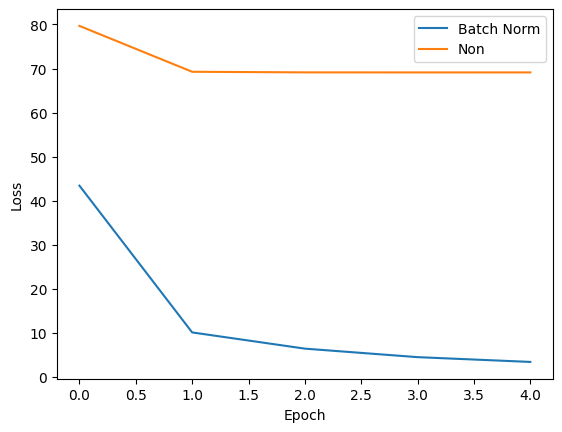

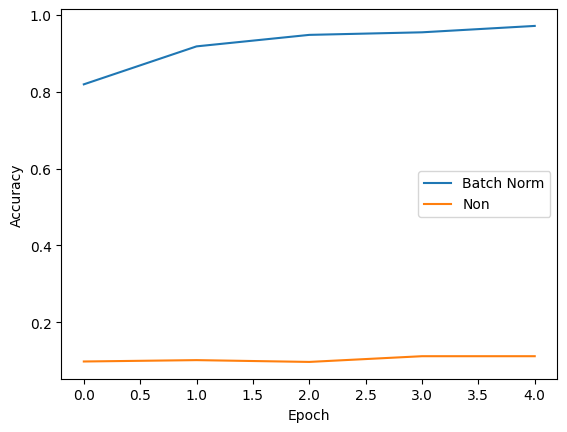

In [6]:
input_dim = 28 * 28
output_dim = 10
Layers = [input_dim, 100, 100, 100, output_dim]
COST = {'Batch Normalization': [], 'Non': []}
ACC = {'Batch Normalization': [], 'Non': []}

model_bn = ANN_BN(Layers)
model_bn.train()
optimizer_bn = optim.Adam(model_bn.parameters(), lr=0.1)
training(model_bn, epochs=5, optimizer=optimizer_bn, method_name='Batch Normalization')

model = ANN(Layers)
optimizer = optim.Adam(model.parameters(), lr=0.1)
training(model, epochs=5, optimizer=optimizer, method_name='Non')

# Show Result
plt.plot(COST['Batch Normalization'], label='Batch Norm')
plt.plot(COST['Non'], label='Non')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Show Result
plt.plot(ACC['Batch Normalization'], label='Batch Norm')
plt.plot(ACC['Non'], label='Non')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [7]:
# Connect to Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
# Save Parameter
model_bn_save_name = 'Batch_Normalization.pth'
model_save_name = 'Non.pth'
path_bn = F"/content/gdrive/MyDrive/{model_bn_save_name}"
path = F"/content/gdrive/MyDrive/{model_save_name}"

torch.save(model_bn.state_dict(), path_bn)
torch.save(model.state_dict(), path)

In [9]:
# Load Parameter Batch Norm Model
model_bn = ANN_BN(Layers)
model = ANN(Layers)
bn_checkpoint_path = F"/content/gdrive/MyDrive/Batch_Normalization.pth"
bn_state_dict = torch.load(bn_checkpoint_path)
model_bn.load_state_dict(bn_state_dict)
model_bn.eval()

# Load Parameter Non Model
model = ANN(Layers)
checkpoint_path = F'/content/gdrive/MyDrive/Non.pth'
state_dict = torch.load(checkpoint_path)
model.load_state_dict(state_dict)


<All keys matched successfully>

In [10]:
m = model_bn(valid_dataset[0][0].view(-1, 28*28))
n = model_bn(valid_dataset[0][0].view(-1, 28*28))
are_equal = torch.equal(m, n)
print(f'Kiem tra 2 model co giong nhau ko: {are_equal}')


Kiem tra 2 model co giong nhau ko: True


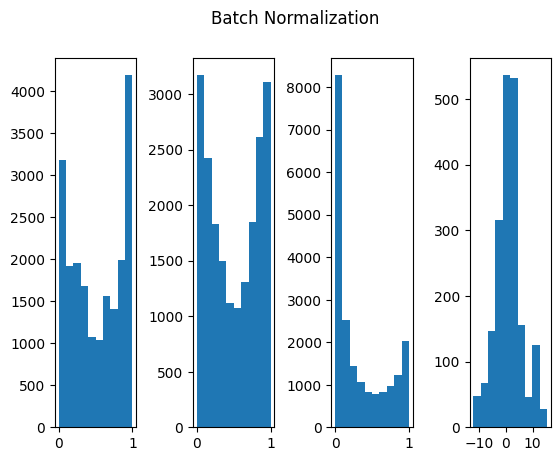

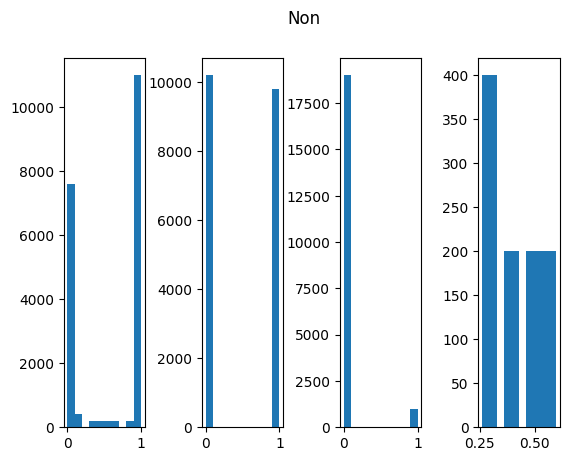

In [11]:
model_bn_out = [[], [], [], []]
model_out = [[], [], [], []]
for i in range(200):

  out_bn = model_bn.output_hidden(valid_dataset[i][0].view(-1, 28*28))
  for i,v in enumerate(out_bn):
    model_bn_out[i].extend(v)

  out = model.output_hidden(valid_dataset[i][0].view(-1, 28*28))
  for i,v in enumerate(out):
    model_out[i].extend(v)

fig,ax = plt.subplots(1, 4)
ax[0].hist(model_bn_out[0])
ax[1].hist(model_bn_out[1])
ax[2].hist(model_bn_out[2])
ax[3].hist(model_bn_out[3])
fig.suptitle("Batch Normalization")
plt.subplots_adjust(wspace=0.7)
plt.show()

fig,ax = plt.subplots(1, 4)
ax[0].hist(model_out[0])
ax[1].hist(model_out[1])
ax[2].hist(model_out[2])
ax[3].hist(model_out[3])
fig.suptitle("Non")
plt.subplots_adjust(wspace=0.7)
plt.show()

**Nhận xét**:   
+ Biểu đồ thứ 4 là đầu ra của hàm Net ở tầng Output, kết quẩ này sẽ được cho vào hàm Softmax để tính xác xuất  
+ Các biểu đồ còn lại của Batch Norm có thể thấy giá trị đầu ra của các tầng ẩn trải đều trong khoảng (0,1).  
+ Các biểu đồ còn lại của Non thì giá trị đầu ra của các tầng ẩn tập trung ở giá trị 0 và 1 nhiều, điều này là không tốt vì giá trị hàm Sigmoid quá lớn có thể dẫn tới việc đạo hàm của nó bằng 0 dẫn tới không cập nhập được gì. (Xem lại đồ thị giá trị đạo hàm của hàm Sigmoid)